In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RB_Sentence1_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 5775
Neutral : 133685
Negative : 748


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1148


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Nature/Parks'][df1['TextBlob Polarity RBS1'] > 0]['RB_Sentence1'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I had the most amazing experience in the incredible Simien Mountains '
 'trekking with Afera from Panoramic Simiens.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['had', 'the', 'most', 'amazing', 'experience', 'in', 'the', 'incredible', 'simien', 'mountains', 'trekking', 'with', 'afera', 'from', 'panoramic', 'simiens']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['had', 'the', 'most', 'amazing', 'experience', 'in', 'the', 'incredible', 'simien', 'mountains', 'trekking', 'with', 'afera', 'from', 'panoramic', 'simiens']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['experience', 'incredible', 'trek', 'panoramic', 'simien']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('experience', 1),
  ('incredible', 1),
  ('panoramic', 1),
  ('simien', 1),
  ('trek', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.092*"view" + 0.055*"scenery" + 0.048*"spectacular" + 0.040*"landscape" + '
  '0.034*"road" + 0.031*"worth" + 0.029*"stunning" + 0.029*"wildlife" + '
  '0.020*"offer" + 0.018*"company"'),
 (1,
  '0.117*"see" + 0.044*"incredible" + 0.044*"hippos" + 0.039*"year" + '
  '0.037*"organise" + 0.029*"include" + 0.027*"drive" + 0.027*"crocodile" + '
  '0.023*"professional" + 0.023*"bird"'),
 (2,
  '0.112*"experience" + 0.048*"people" + 0.036*"make" + 0.035*"find" + '
  '0.031*"unforgettable" + 0.031*"hike" + 0.023*"part" + 0.023*"go" + '
  '0.021*"say" + 0.021*"magic"'),
 (3,
  '0.124*"time" + 0.054*"walk" + 0.053*"tribe" + 0.040*"local" + 0.039*"long" '
  '+ 0.024*"much" + 0.023*"different" + 0.022*"cultural" + 0.019*"tourist" + '
  '0.018*"recent"'),
 (4,
  '0.064*"get" + 0.048*"close" + 0.047*"absolutely" + 0.044*"well" + '
  '0.043*"many" + 0.042*"baboon" + 0.034*"arrange" + 0.024*"plan" + '
  '0.023*"use" + 0.023*"full"'),
 (5,
  '0.071*"area" + 0.053*"want" + 0.041*"do" + 0.040*"

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.058277628546564

Coherence Score:  0.5555558495646391


In [17]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('view', 0.13052208835341367),
   ('landscape', 0.0823293172690763),
   ('spectacular', 0.07429718875502007),
   ('animal', 0.04819277108433735),
   ('high', 0.03815261044176707),
   ('road', 0.02208835341365462),
   ('large', 0.02208835341365462),
   ('range', 0.020080321285140562),
   ('hippos', 0.01606425702811245),
   ('bird', 0.01606425702811245)]),
 (1,
  [('time', 0.16727272727272727),
   ('visit', 0.11272727272727273),
   ('tribe', 0.08545454545454545),
   ('worth', 0.04181818181818182),
   ('book', 0.03272727272727273),
   ('live', 0.02909090909090909),
   ('long', 0.025454545454545455),
   ('driver', 0.02181818181818182),
   ('adventure', 0.02181818181818182),
   ('southern', 0.02)]),
 (2,
  [('scenery', 0.08133086876155268),
   ('walk', 0.06284658040665435),
   ('area', 0.06099815157116451),
   ('baboon', 0.04621072088724584),
   ('stunning', 0.04621072088724584),
   ('include', 0.04251386321626617),
   ('place', 0.04066543438077634),
   ('group', 0.03512014787430684

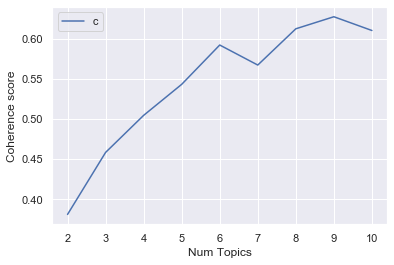

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.381
Num Topics = 3  has Coherence Value of 0.4584
Num Topics = 4  has Coherence Value of 0.5046
Num Topics = 5  has Coherence Value of 0.5433
Num Topics = 6  has Coherence Value of 0.5923
Num Topics = 7  has Coherence Value of 0.5673
Num Topics = 8  has Coherence Value of 0.6125
Num Topics = 9  has Coherence Value of 0.6276
Num Topics = 10  has Coherence Value of 0.6104


In [20]:
# optimal_model = model_list[7] # Number of Topics = 9

optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=9, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.265*"trip" + 0.053*"area" + 0.048*"make" + 0.041*"find" + 0.039*"part" + '
  '0.036*"organize" + 0.031*"guide" + 0.026*"highlight" + 0.024*"arrange" + '
  '0.021*"adventure"'),
 (1,
  '0.149*"guide" + 0.109*"night" + 0.070*"scenery" + 0.045*"hike" + '
  '0.045*"simien" + 0.040*"day" + 0.037*"include" + 0.029*"stay" + '
  '0.027*"bird" + 0.026*"expect"'),
 (2,
  '0.193*"experience" + 0.093*"travel" + 0.061*"local" + 0.039*"place" + '
  '0.034*"unforgettable" + 0.034*"group" + 0.030*"bale" + 0.027*"natural" + '
  '0.025*"culture" + 0.020*"large"'),
 (3,
  '0.110*"visit" + 0.083*"tribe" + 0.039*"organise" + 0.039*"landscape" + '
  '0.028*"live" + 0.028*"world" + 0.025*"life" + 0.023*"give" + '
  '0.019*"crocodile" + 0.019*"southern"'),
 (4,
  '0.392*"day" + 0.118*"spend" + 0.061*"spectacular" + 0.034*"start" + '
  '0.016*"thing" + 0.015*"boat" + 0.013*"hour" + 0.013*"short" + 0.013*"half" '
  '+ 0.010*"reach"'),
 (5,
  '0.168*"trek" + 0.094*"view" + 0.058*"walk" + 0.048*"wildlif

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1374,"trek, view, walk, wildlife, animal, nature, ca...",I had the most amazing experience in the incre...
1,1,6.0,0.1528,"tour, absolutely, high, landscape, monkey, boo...",Its been a splendor and amazing experience fro...
2,2,3.0,0.1285,"visit, tribe, organise, landscape, live, world...",Excellent trek in Simien - well organised by D...
3,3,1.0,0.1218,"guide, night, scenery, hike, simien, day, incl...",Simien Mountains offer great views.
4,4,1.0,0.1475,"guide, night, scenery, hike, simien, day, incl...","Majestic scenery, testing terrain at times so ..."
5,5,1.0,0.1261,"guide, night, scenery, hike, simien, day, incl...",The 7-day trek took us through exquisite scene...
6,6,8.0,0.1399,"time, recommend, baboon, stunning, year, close...","Coming from France ,I have visited Ethiopia fo..."
7,7,1.0,0.1303,"guide, night, scenery, hike, simien, day, incl...",We went to the Simien Mountains in the first d...
8,8,2.0,0.1261,"experience, travel, local, place, unforgettabl...",Omo Valley seemed to me as a unique place in E...
9,9,3.0,0.1733,"visit, tribe, organise, landscape, live, world...","The magnicifent Omo Valley, located in East Af..."


In [22]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    268
1.0    143
2.0    135
4.0    131
5.0    128
6.0    122
3.0    113
7.0     97
8.0     89
Name: Dominant_Topic, dtype: int64

In [33]:
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Trekking/Hiking Experience - 268
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Visual (Aesthetic, Scenery, etc.) - 143
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # General Appreciation - 135
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # General Appreciation - 113
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Appreciation - 131
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Trekking/Hiking Experience - 128
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # General Appreciation - 122
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Tour Guide - 97
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Visual (Aesthetic, Scenery, etc.) - 89

In [34]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1726,"trip, area, make, find, part, organize, guide,...",Our guide Birku Tesfaw organized our trip to S...
1,1.0,0.2183,"guide, night, scenery, hike, simien, day, incl...",Great hike in the Simiens although more diffic...
2,2.0,0.1910,"experience, travel, local, place, unforgettabl...",If you looking for a cheap but awesome experie...
3,3.0,0.1880,"visit, tribe, organise, landscape, live, world...",around the omo national park there are many tr...
4,4.0,0.1717,"day, spend, spectacular, start, thing, boat, h...",This park has many different grades for hiking...
5,5.0,0.1697,"trek, view, walk, wildlife, animal, nature, ca...",The park is not very large and surprisingly yo...
6,6.0,0.1902,"tour, absolutely, high, landscape, monkey, boo...",In January 2017 I went on a 12 day photo tour ...
7,7.0,0.1832,"people, week, incredible, unique, lot, region,...",We have recently returned from an incredible 5...
8,8.0,0.1907,"time, recommend, baboon, stunning, year, close...",Forest looks like a bunch of broccoli when you...


In [35]:
sent_topics_sorteddf_mallet['Text'].values

array(['Our guide Birku Tesfaw organized our trip to Simien mountains and to other parts of Etiopia, if anybody want to have good guide call him.',
       'Great hike in the Simiens although more difficult than expected and extremely cold camping at night.',
       'If you looking for a cheap but awesome experience around the Omo valley tribes, check Baby Jinka, he knows the surrounding as he is local, he took us very nice places with minibus and very experience driver, very reasonable price for backpackers with limited budget,...',
       'around the omo national park there are many tribes who lives with different costumes culture and thise tribes like mursi, dassanech/geleb/ are so wild in their life they are bared body ,they have nothing to wear because of their culture and they put clay or...',
       'This park has many different grades for hiking from half a day to several days.',
       'The park is not very large and surprisingly you can actually view animals walking in the par

In [27]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics